In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating Embeddings of items in FasionMNIST with an autoencoder
![](https://www.compthree.com/images/blog/ae/ae.png)

In [10]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from model import AutoEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# reproducibility
torch.manual_seed(5);

#### Config

In [12]:
BATCH_SIZE = 64
DEVICE = (torch.device("cuda") if torch.cuda.is_available() 
          else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")))

ENCODER_PARAMS = [28 * 28, 512, 256, 3]
DECODER_PARAMS = [3, 256, 512, 28 * 28]

#### Load FashionMNIST

In [13]:
train_set = FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_set = FashionMNIST(
    root="./data",
    train=False,
    download=False,
    transform=ToTensor()
)

#### Split train into train and validation
80/20 split

In [14]:
split = [0.8, 0.2]
train_set, val_set = random_split(train_set, split)

In [15]:
len(train_set), len(val_set), len(test_set)

(48000, 12000, 10000)

#### Visualize Data

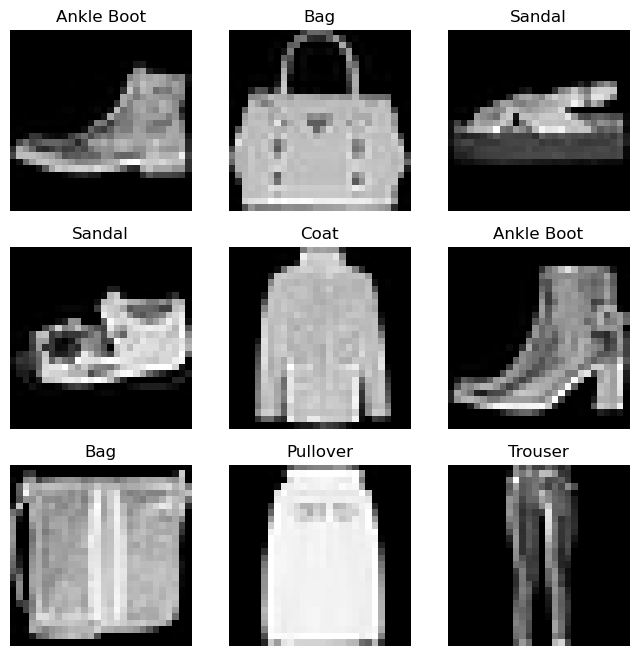

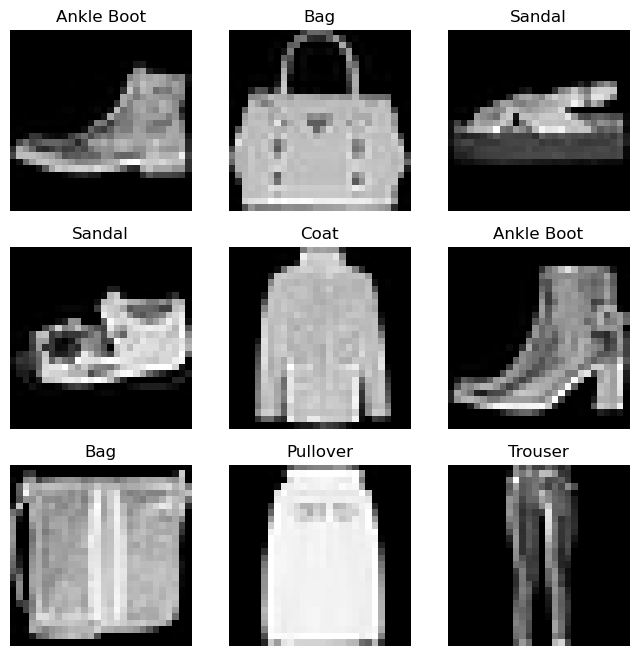

In [16]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Create dataloaders

In [28]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

#### Create autoencoder

In [297]:
autoencoder = AutoEncoder(encoder_params=ENCODER_PARAMS, decoder_params=DECODER_PARAMS)

In [298]:
autoencoder

AutoEncoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=512, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
      )
      (2): Linear(in_features=256, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
      )
      (2): Linear(in_features=512, out_features=784, bias=True)
    )
  )
)

#### Set up training

In [299]:
LR = 3e-4

In [300]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

#### Overfit on 1 item

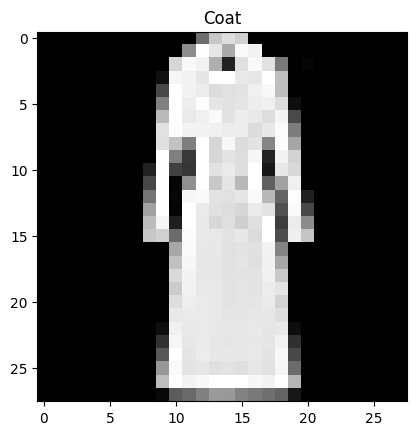

In [301]:
mini_batch = train_set[0]

plt.title(labels_map[mini_batch[1]])
plt.imshow(mini_batch[0][0], cmap="gray");

In [302]:
X = mini_batch[0].unsqueeze(0)
Y = torch.tensor([mini_batch[1]])

batch = (X, Y)

In [303]:
def train_batch(batch, model, criterion, optimizer, device):
    model.train()
    
    X, Y = batch
    X = X.to(device)
    X = X.view(-1, 28*28)

    # reconstructed X
    X_hat = model(X)
    
    loss = criterion(X_hat, X)
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [304]:
autoencoder = autoencoder.to(DEVICE)
epochs = 50

In [305]:
for i in range(epochs):
    loss = train_batch(batch, autoencoder, criterion, optimizer, DEVICE)
    print(f"[Epoch {i + 1}]: Loss={loss.item()}")

[Epoch 1]: Loss=0.26059216260910034
[Epoch 2]: Loss=0.2516874670982361
[Epoch 3]: Loss=0.2436736673116684
[Epoch 4]: Loss=0.23559461534023285
[Epoch 5]: Loss=0.2268536537885666
[Epoch 6]: Loss=0.216959610581398
[Epoch 7]: Loss=0.2056962251663208
[Epoch 8]: Loss=0.1925675868988037
[Epoch 9]: Loss=0.1773611158132553
[Epoch 10]: Loss=0.15959589183330536
[Epoch 11]: Loss=0.13914412260055542
[Epoch 12]: Loss=0.11612371355295181
[Epoch 13]: Loss=0.09140119701623917
[Epoch 14]: Loss=0.06693893671035767
[Epoch 15]: Loss=0.045999571681022644
[Epoch 16]: Loss=0.03327399119734764
[Epoch 17]: Loss=0.03249874711036682
[Epoch 18]: Loss=0.03824612498283386
[Epoch 19]: Loss=0.03876374289393425
[Epoch 20]: Loss=0.031588923186063766
[Epoch 21]: Loss=0.02092801034450531
[Epoch 22]: Loss=0.011358988471329212
[Epoch 23]: Loss=0.005387531127780676
[Epoch 24]: Loss=0.003234407864511013
[Epoch 25]: Loss=0.00377197889611125
[Epoch 26]: Loss=0.005502563435584307
[Epoch 27]: Loss=0.007225991226732731
[Epoch 28]:

##### Embedding

In [306]:
autoencoder.eval()

ground_truth = X.view(-1, 28*28).to(DEVICE)
embedding = autoencoder.encoder(ground_truth)[0]
embedding.detach()

tensor([-0.4136,  1.5999, -1.9103], device='mps:0')

##### Compare x to $\hat{x}$

In [307]:
X_hat = autoencoder(ground_truth)

X = ground_truth[0].view(28, 28).cpu().detach()
X_hat = X_hat[0].view(28, 28).cpu().detach()

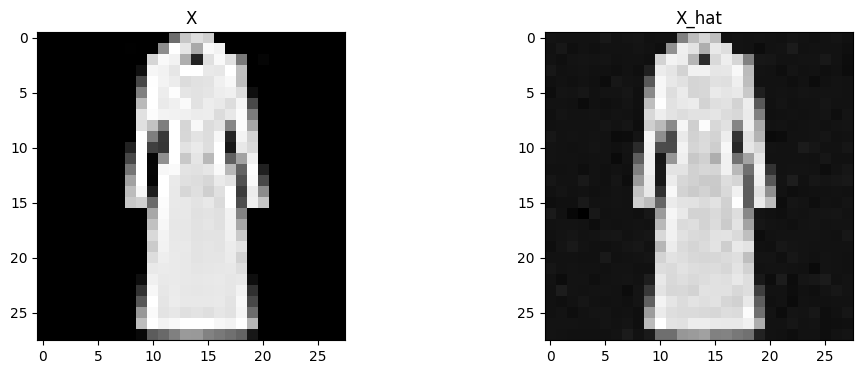

In [308]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title("X")
ax2.set_title("X_hat")

ax1.imshow(X, cmap="gray")
ax2.imshow(X_hat, cmap="gray");

#### Training
Train on train dataset

In [24]:
autoencoder = AutoEncoder(encoder_params=ENCODER_PARAMS, decoder_params=DECODER_PARAMS)

In [25]:
LR = 3e-4

In [26]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

##### Train and Eval Functions

In [21]:
def eval_loss(model, criterion, loader, device):
    model.eval()
    
    total_loss = 0
    for X, Y in loader:
        X = X.to(device)
        X = X.view(-1, 28*28)
        
        X_hat = model(X)
        loss = criterion(X_hat, X)
        total_loss += loss
    
    return total_loss / len(loader)

In [314]:
def train(model, criterion, optimizer, epochs, train_loader, val_loader, path, device):
    print("TRAINING")
    
    model.train()
    model = model.to(device)
    
    losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Epoch {epoch + 1}/{epochs}]", leave=False):
            loss = train_batch(batch, model, criterion, optimizer, device)
            total_loss += loss
            
        train_loss = total_loss / len(train_loader)
        val_loss = eval_loss(model, criterion, val_loader, device)
        
        losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        print(f"[Epoch {epoch + 1}/{epochs}]: Loss={train_loss}, Val Loss={val_loss}")
        
    # save weights
    torch.save(model, path)
        
    return losses, val_losses

##### Train Config

In [18]:
EPOCHS = 50
PATH = "weights.pth"

##### Training...

In [318]:
torch.mps.empty_cache()

In [319]:
train_losses, val_losses = train(autoencoder, criterion, optimizer,
      epochs=EPOCHS,
      train_loader=train_loader,
      val_loader=val_loader,
      path=PATH,
      device=DEVICE)

TRAINING


[Epoch 1/50]: Loss=0.034422677010297775, Val Loss=0.025992542505264282


[Epoch 2/50]: Loss=0.024729054421186447, Val Loss=0.02409694343805313


[Epoch 3/50]: Loss=0.023464063182473183, Val Loss=0.023114612326025963


[Epoch 4/50]: Loss=0.022811418399214745, Val Loss=0.0226571187376976


[Epoch 5/50]: Loss=0.022370686754584312, Val Loss=0.02224932797253132


[Epoch 6/50]: Loss=0.022021977230906487, Val Loss=0.022010134533047676


[Epoch 7/50]: Loss=0.021754348650574684, Val Loss=0.021725930273532867


[Epoch 8/50]: Loss=0.021518316119909286, Val Loss=0.021555421873927116


[Epoch 9/50]: Loss=0.021316522732377052, Val Loss=0.021473724395036697


[Epoch 10/50]: Loss=0.021159177646040916, Val Loss=0.021207286044955254


[Epoch 11/50]: Loss=0.02101476490497589, Val Loss=0.021150674670934677


[Epoch 12/50]: Loss=0.020878467708826065, Val Loss=0.021161340177059174


[Epoch 13/50]: Loss=0.020734956488013268, Val Loss=0.020911457017064095


[Epoch 14/50]: Loss=0.02061830461025238, Val Loss=0.020828895270824432


[Epoch 15/50]: Loss=0.020507294684648514, Val Loss=0.02075299434363842


[Epoch 16/50]: Loss=0.020413853228092194, Val Loss=0.020643897354602814


[Epoch 17/50]: Loss=0.02032303251326084, Val Loss=0.020668091252446175


[Epoch 18/50]: Loss=0.020238174125552177, Val Loss=0.020524905994534492


[Epoch 19/50]: Loss=0.020166607573628426, Val Loss=0.02052110619843006


[Epoch 20/50]: Loss=0.020092621445655823, Val Loss=0.02038910798728466


[Epoch 21/50]: Loss=0.019995974376797676, Val Loss=0.020440684631466866


[Epoch 22/50]: Loss=0.019938161596655846, Val Loss=0.020470181480050087


[Epoch 23/50]: Loss=0.01987692341208458, Val Loss=0.020238380879163742


[Epoch 24/50]: Loss=0.01981799490749836, Val Loss=0.0202541071921587


[Epoch 25/50]: Loss=0.01975756511092186, Val Loss=0.020209498703479767


[Epoch 26/50]: Loss=0.019692575559020042, Val Loss=0.020129535347223282


[Epoch 27/50]: Loss=0.019646167755126953, Val Loss=0.020115941762924194


[Epoch 28/50]: Loss=0.019617395475506783, Val Loss=0.020110968500375748


[Epoch 29/50]: Loss=0.01956113986670971, Val Loss=0.020067531615495682


[Epoch 30/50]: Loss=0.019522039219737053, Val Loss=0.020081371068954468


[Epoch 31/50]: Loss=0.019459635019302368, Val Loss=0.019994985312223434


[Epoch 32/50]: Loss=0.019419070333242416, Val Loss=0.020023329183459282


[Epoch 33/50]: Loss=0.019398218020796776, Val Loss=0.019981786608695984


[Epoch 34/50]: Loss=0.01933199353516102, Val Loss=0.019884202629327774


[Epoch 35/50]: Loss=0.01930737867951393, Val Loss=0.01994619145989418


[Epoch 36/50]: Loss=0.019253935664892197, Val Loss=0.019867993891239166


[Epoch 37/50]: Loss=0.019214659929275513, Val Loss=0.01984464004635811


[Epoch 38/50]: Loss=0.01922106370329857, Val Loss=0.01990850642323494


[Epoch 39/50]: Loss=0.019192151725292206, Val Loss=0.01980944722890854


[Epoch 40/50]: Loss=0.01912866160273552, Val Loss=0.019734473899006844


[Epoch 41/50]: Loss=0.01909363642334938, Val Loss=0.019778264686465263


[Epoch 42/50]: Loss=0.01906159520149231, Val Loss=0.01980159804224968


[Epoch 43/50]: Loss=0.019040798768401146, Val Loss=0.019697776064276695


[Epoch 44/50]: Loss=0.019006606191396713, Val Loss=0.019722407683730125


[Epoch 45/50]: Loss=0.018969710916280746, Val Loss=0.019683819264173508


[Epoch 46/50]: Loss=0.01896427571773529, Val Loss=0.019700726494193077


[Epoch 47/50]: Loss=0.018928246572613716, Val Loss=0.019695593044161797


[Epoch 48/50]: Loss=0.018900224938988686, Val Loss=0.019673723727464676


[Epoch 49/50]: Loss=0.018889060243964195, Val Loss=0.01968841440975666


[Epoch 50/50]: Loss=0.01885107532143593, Val Loss=0.01964516192674637


##### Training Loss vs. Validation Loss

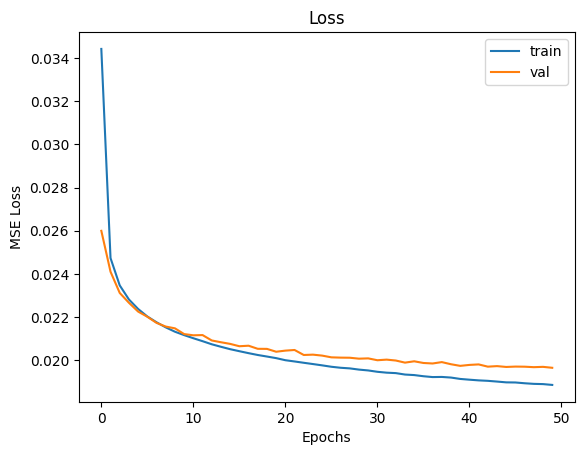

In [324]:
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

x = range(EPOCHS)
plt.plot(x, train_losses, label="train")
plt.plot(x, val_losses, label="val")

plt.legend()

#### Evaluation
MSE Loss on test set

In [30]:
autoencoder = AutoEncoder(encoder_params=ENCODER_PARAMS, decoder_params=DECODER_PARAMS)
autoencoder.load_state_dict(torch.load(PATH).state_dict())
autoencoder = autoencoder.to(DEVICE)

In [31]:
test_loss = eval_loss(autoencoder, criterion, test_loader, device=DEVICE).item()
print(f"Test Loss: {test_loss}")

Test Loss: 0.01966911181807518


#### Embeddings
3d interactive plot of fashion mnist embeddings

In [32]:
labels_color = {
    0: 'b',
    1: 'g',
    2: 'r',
    3: 'c',
    4: 'm',
    5: 'y',
    6: 'k',
    7: 'w',
    8: 'purple',
    9: 'orange'
}

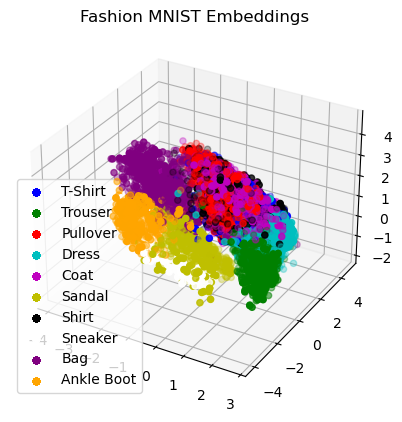

In [33]:
# for each batch, create embeddings then display them
fig = plt.figure()
# ax = Axes3D(fig)

ax = fig.add_subplot(111, projection='3d')

ax.set_title("Fashion MNIST Embeddings")

plots = {
    0: [],
    1: [],
    2: [],
    3: [],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: []
}

autoencoder.eval()
for X, Y in test_loader:
    X = X.to(DEVICE)
    X = X.view(-1, 28*28)
    X_hat = autoencoder.encoder(X)
    X_hat = X_hat.detach().cpu().numpy()
    
    # for each label, plot their embeddings
    for label in labels_map.keys():
        X_hat_for_label = X_hat[Y == label]
        x = X_hat_for_label[:, 0]
        y = X_hat_for_label[:, 1]
        z = X_hat_for_label[:, 2]
        
        color = labels_color[label]
        label_name = labels_map[label]
        
        plot = ax.scatter(x, y, z, c=color)
        plots[label].append(plot)

plots = list(tuple(plots) for plots in plots.values())
labels = list(labels_map.values())

plt.legend(plots, labels);
plt.show();